# Fit bambi model to males and females combined

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, dissoc
from aging.behavior.bio_age_model import fit_model, masked_xval, model_fun_v5, get_biological_age, compute_concentrations, concentration_interpolation, create_masks, expected_counts, compute_heldout_r2, model_setup, model_fun_v2
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA

In [123]:
syllable_classes = pd.read_csv('./v11_syllable_labels_v2.csv')
id_map = syllable_classes.set_index('Original ID')['Class']

In [2]:
format_plots()
c = PlotConfig()
# saver = save_factory(c.save_path / "fig4", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [6]:
df, sizes_col = read_male_ontogeny(keep_syllables)
# female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
# df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

# label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
# sex_id = label_encoder.fit_transform(
#     np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
# ).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [7]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    # "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    # "mice": sex_id,
}

hypparams = {
    # "min_age": 1,
    "min_age": -10,
    # "max_age": age.max() + 5,
    "max_age": 150,
    "age_sd": 10,  # weeks
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    # "n_animals": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 300,
}

In [8]:
mdl = fit_model(features, hypparams, 2)

In [9]:
pca = PCA(n_components=3)
scores = pca.fit_transform(df)
bio_pred_scores = pca.transform(mdl['predicted_counts'])
bio_pred_scores_df = pd.DataFrame(bio_pred_scores, index=df.index)

scores_df = pd.DataFrame(scores, index=df.index)

age_np = pd.Series(np.array(age))

bio_age_map = pd.qcut(mdl['bio_ages'], len(np.unique(age_np)), labels=False)
scores_df['bio_age'] = bio_age_map
scores_df = scores_df.set_index('bio_age', append=True)

bio_pred_scores_df['bio_age'] = bio_age_map
bio_pred_scores_df = bio_pred_scores_df.set_index('bio_age', append=True)

avgs = scores_df.groupby('age').mean()
bio_avgs = scores_df.groupby('bio_age').mean()
bio_pred_avgs = bio_pred_scores_df.groupby('age').mean()
bio_pred_avgs_bio = bio_pred_scores_df.groupby('bio_age').mean()

In [10]:
norm = plt.Normalize(vmin=avgs.index.min(), vmax=avgs.index.max())
cmap = plt.colormaps['viridis']
norm2 = plt.Normalize(vmin=bio_avgs.index.min(), vmax=bio_avgs.index.max())
cmap2 = plt.colormaps['inferno']
cmap3 = plt.colormaps['turbo']
cmap4 = plt.colormaps['twilight']

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from toolz import sliding_window
from matplotlib.colors import LinearSegmentedColormap

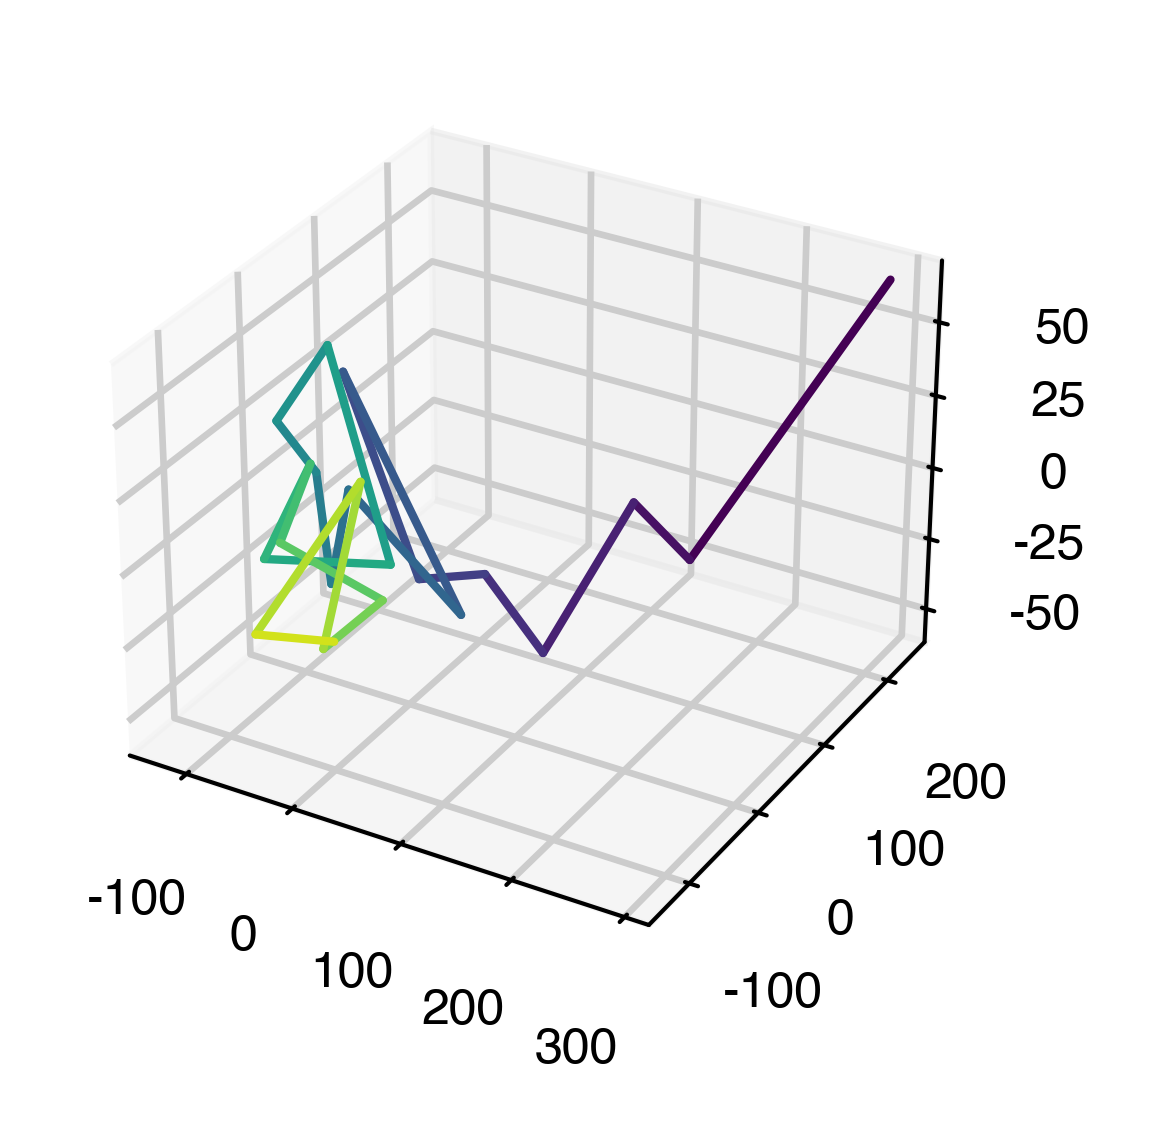

In [12]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap3(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs_bio.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))

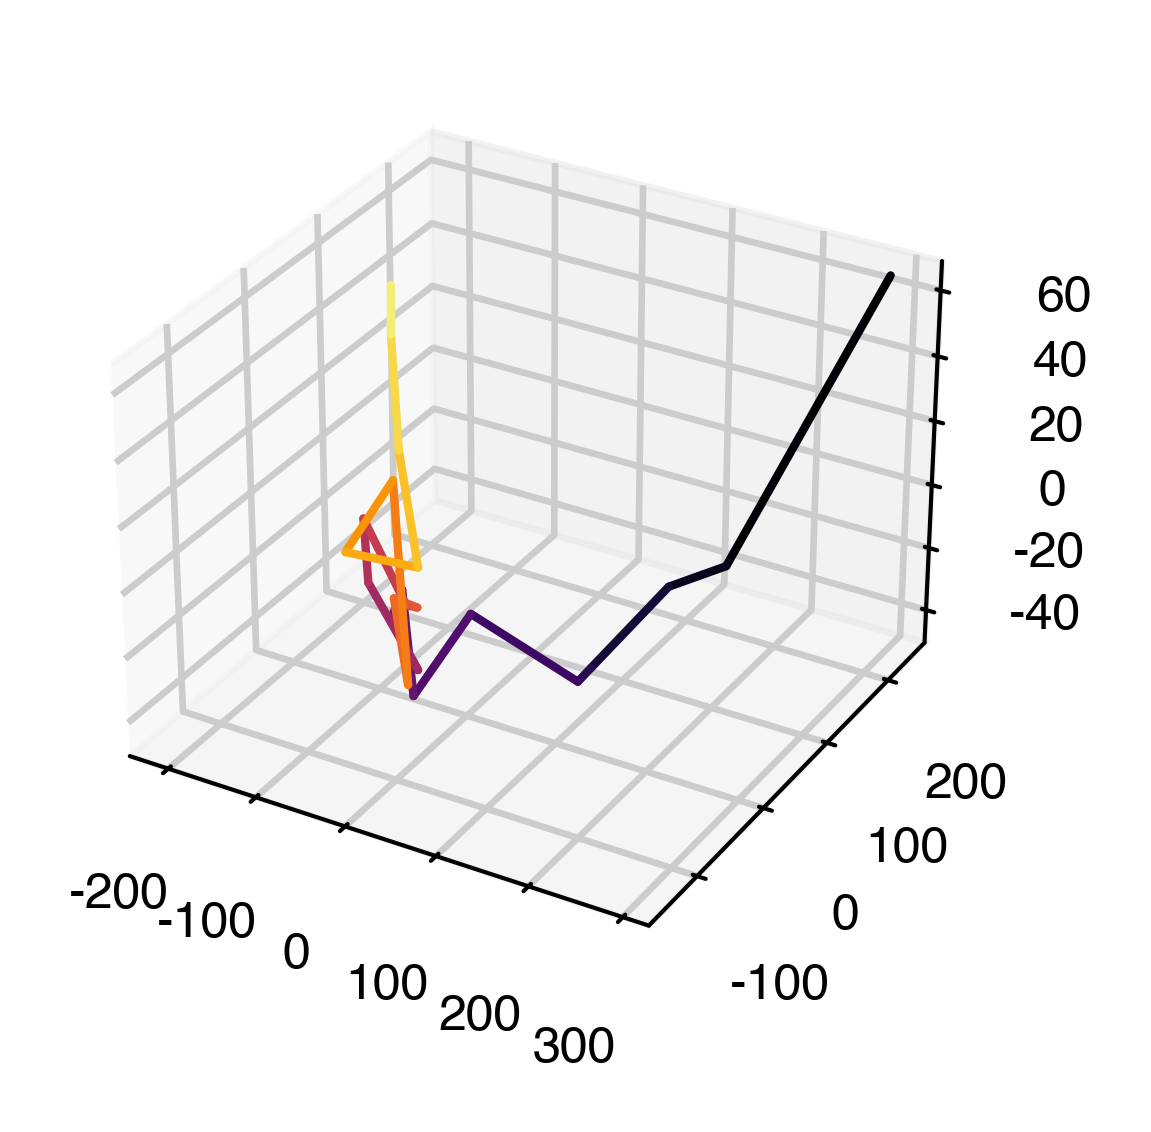

In [13]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap3(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs_bio.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))

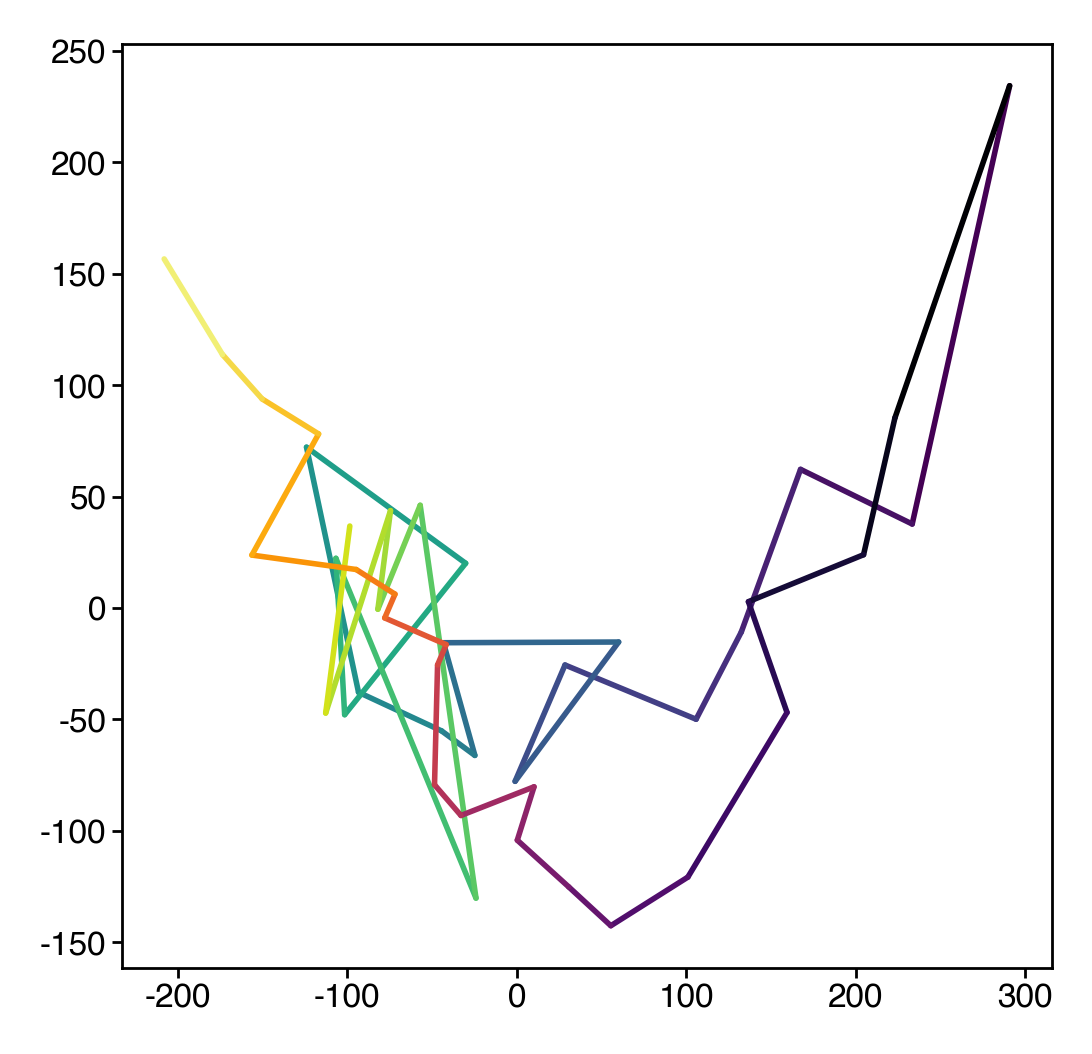

In [14]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

In [83]:
hypparams['age_sd'] = 6
mdl = fit_model(features, hypparams, 2)

In [84]:
pca = PCA(n_components=2)
scores = pca.fit_transform(df)
scores_df = pd.DataFrame(scores, index=df.index)

age_np = pd.Series(np.array(age))

bio_age_map = pd.qcut(mdl['bio_ages'], len(np.unique(age_np)), labels=False)
scores_df['bio_age'] = bio_age_map
scores_df = scores_df.set_index('bio_age', append=True)

avgs = scores_df.groupby('age').mean()
bio_avgs = scores_df.groupby('bio_age').mean()

In [85]:
norm = plt.Normalize(vmin=avgs.index.min(), vmax=avgs.index.max())
cmap = plt.colormaps['viridis']
norm2 = plt.Normalize(vmin=bio_avgs.index.min(), vmax=bio_avgs.index.max())
cmap2 = plt.colormaps['inferno']

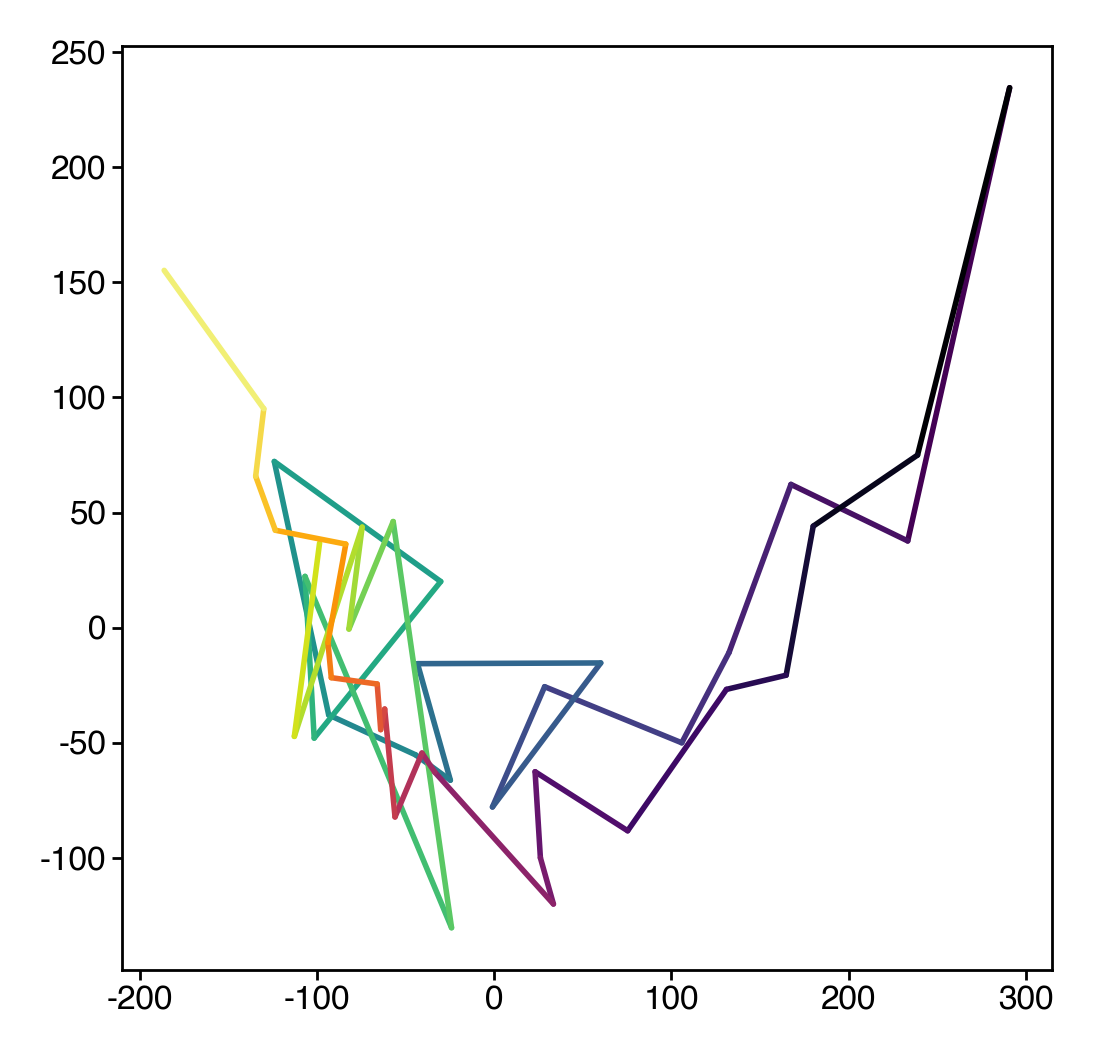

In [86]:
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap2(norm2(_age1)))

### NMF - counts

In [15]:
from sklearn.decomposition import NMF

In [131]:
nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(df)

In [132]:
bam = pd.Series(mdl['bio_ages']).groupby(bio_age_map).mean()

In [133]:
nmf_scores_df = pd.DataFrame(scores, df.index)
nmf_scores_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
nmf_scores_df = nmf_scores_df.set_index('bio_age', append=True)

<Axes: xlabel='age'>

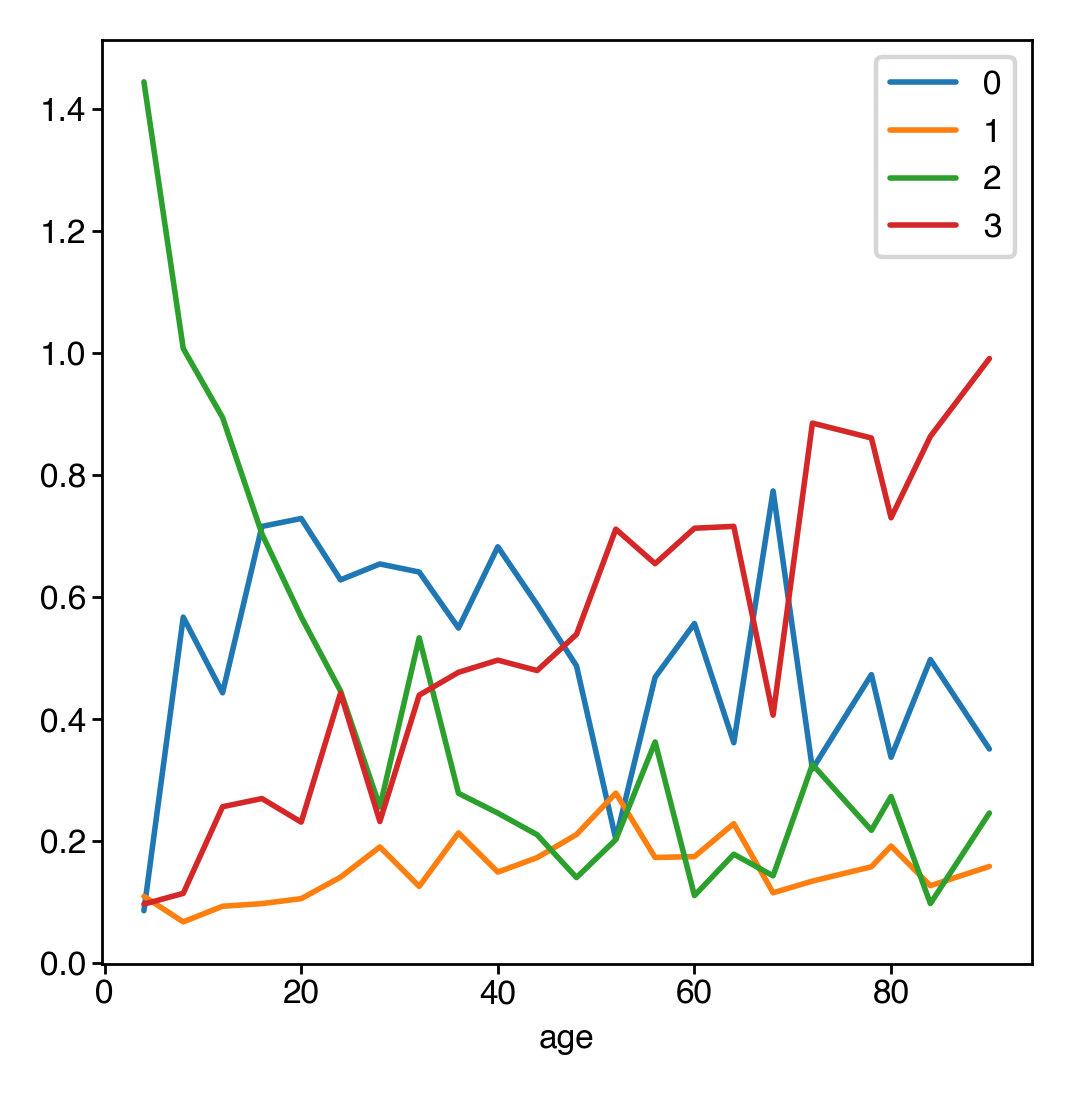

In [134]:
nmf_scores_df.groupby('age').mean().plot()

<Axes: xlabel='bio_age'>

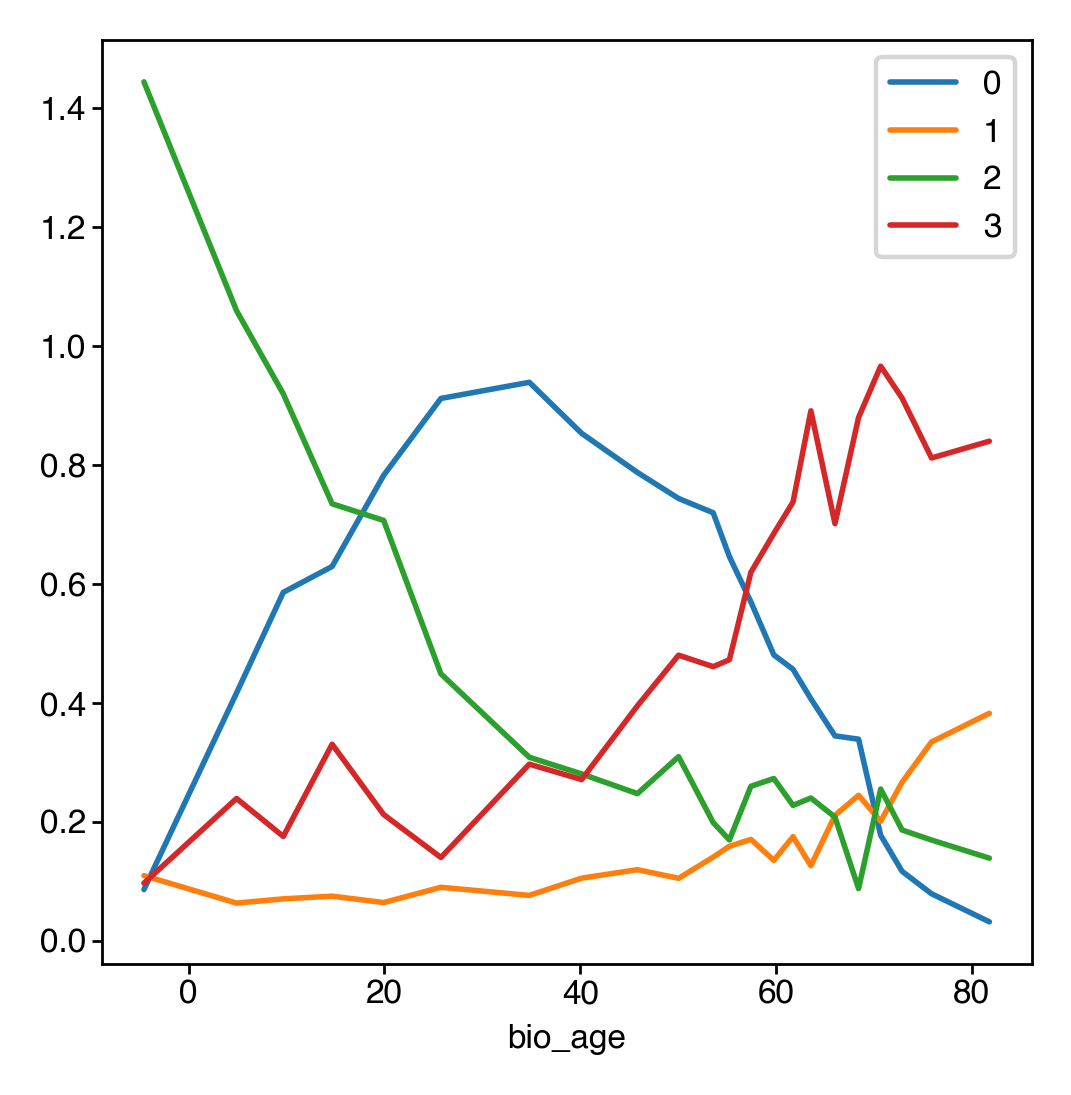

In [135]:
nmf_scores_df.groupby('bio_age').mean().plot()

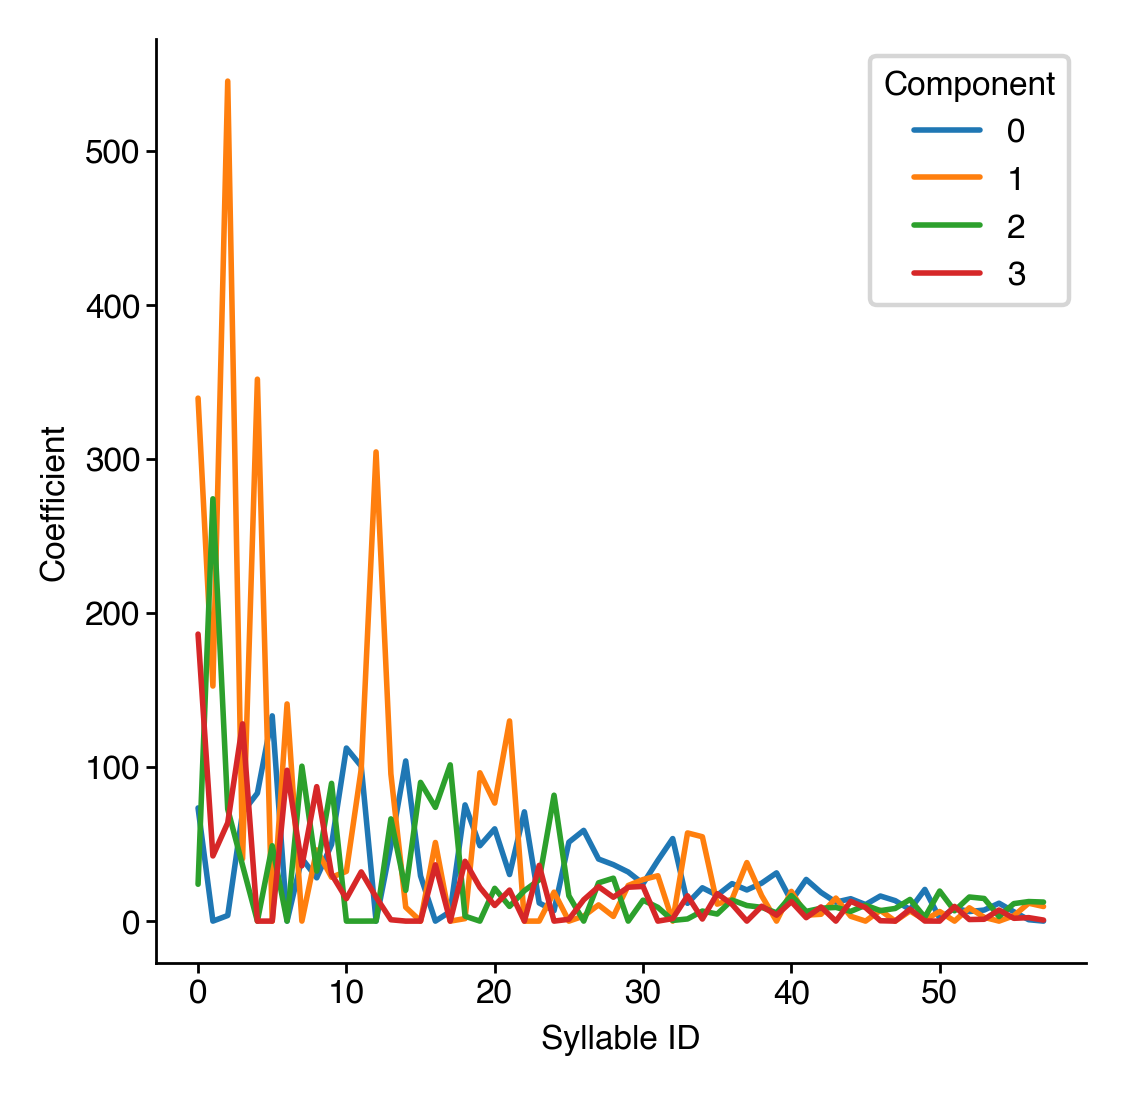

In [136]:
coefs = nmf.components_

srt_idx = np.argsort(df.quantile(0.9).to_numpy())[::-1]

plt.plot(coefs[:, srt_idx].T, label=range(4))
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")
plt.legend(title="Component")
sns.despine()

Text(0, 0.5, 'Coefficient')

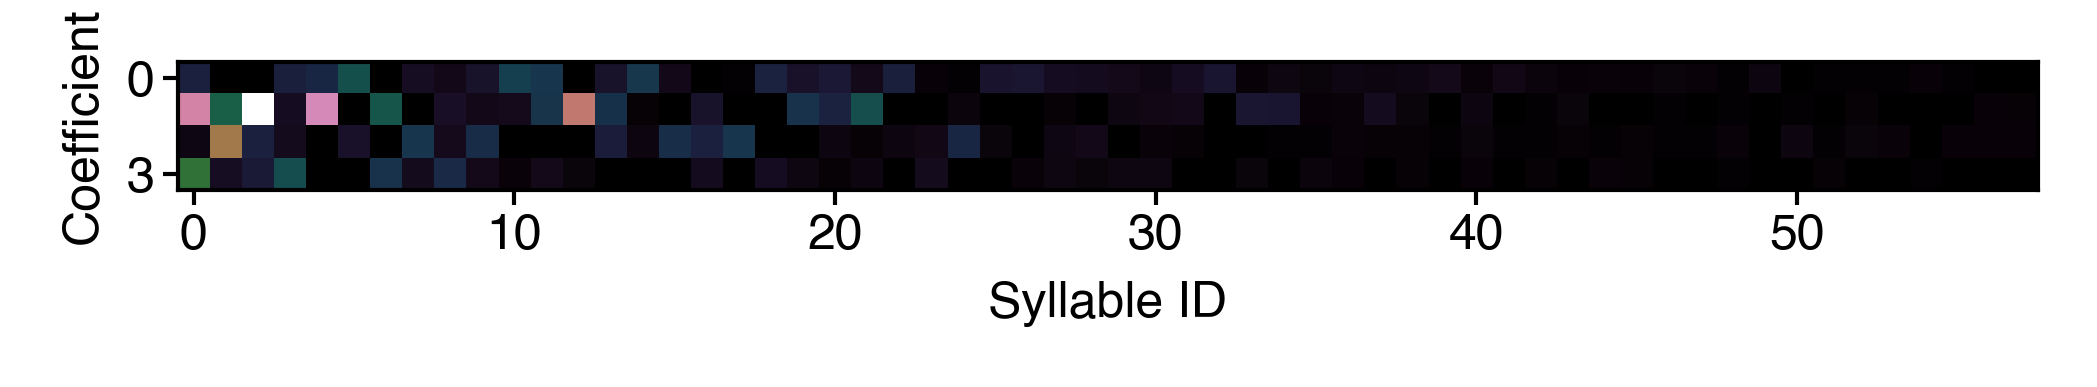

In [137]:
figure(4, 2)
plt.imshow(coefs[:, srt_idx], cmap='cubehelix')
plt.yticks([0, 3])
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")

In [138]:
syllable_coef_map = pd.DataFrame(dict(zip(df.columns, np.argmax(coefs, axis=0))), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()
syllable_coef_map['syll_class'] = syllable_coef_map['syllable'].map(id_map)
syllable_coef_map.groupby('component')['syll_class'].value_counts()

component  syll_class 
0          Rear up        13
           Rear down       3
           Run             3
           Walk            3
           Investigate     2
1          Investigate     5
           Groom           3
           Rear up         3
           Walk            2
           Pause           1
           Rear down       1
2          Rear up         6
           Walk            3
           Pause           2
           Rear down       1
           Run             1
           Scrunch         1
3          Walk            2
           Pause           1
           Rear up         1
           Run             1
Name: count, dtype: int64

### NMF - usages

In [139]:
nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(df / (df.sum(1).to_numpy()[:, None]))

In [140]:
bam = pd.Series(mdl['bio_ages']).groupby(bio_age_map).mean()

In [141]:
nmf_scores_df = pd.DataFrame(scores, df.index)
nmf_scores_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
nmf_scores_df = nmf_scores_df.set_index('bio_age', append=True)

<Axes: xlabel='age'>

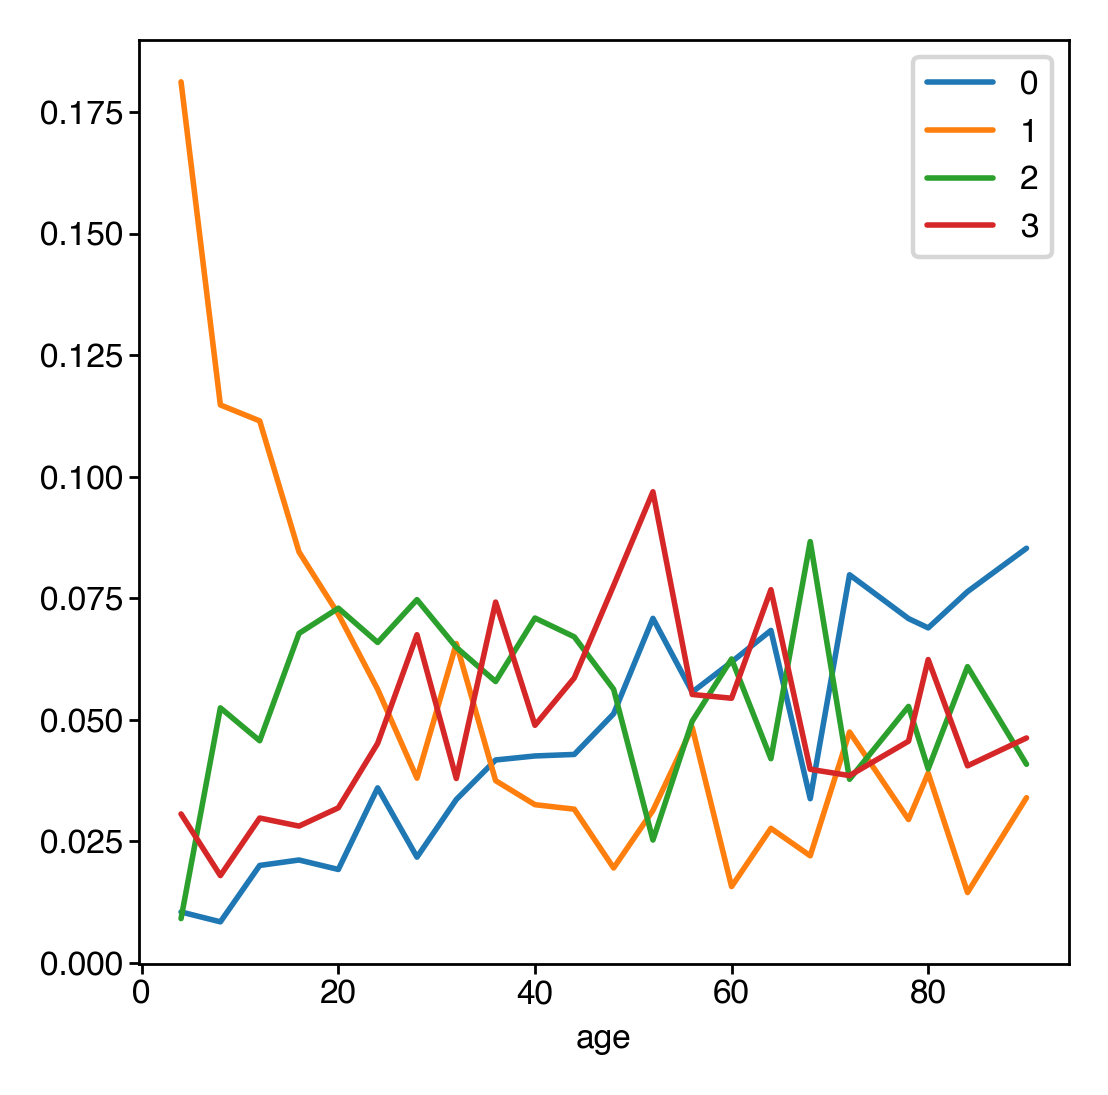

In [142]:
nmf_scores_df.groupby('age').mean().plot()

<Axes: xlabel='bio_age'>

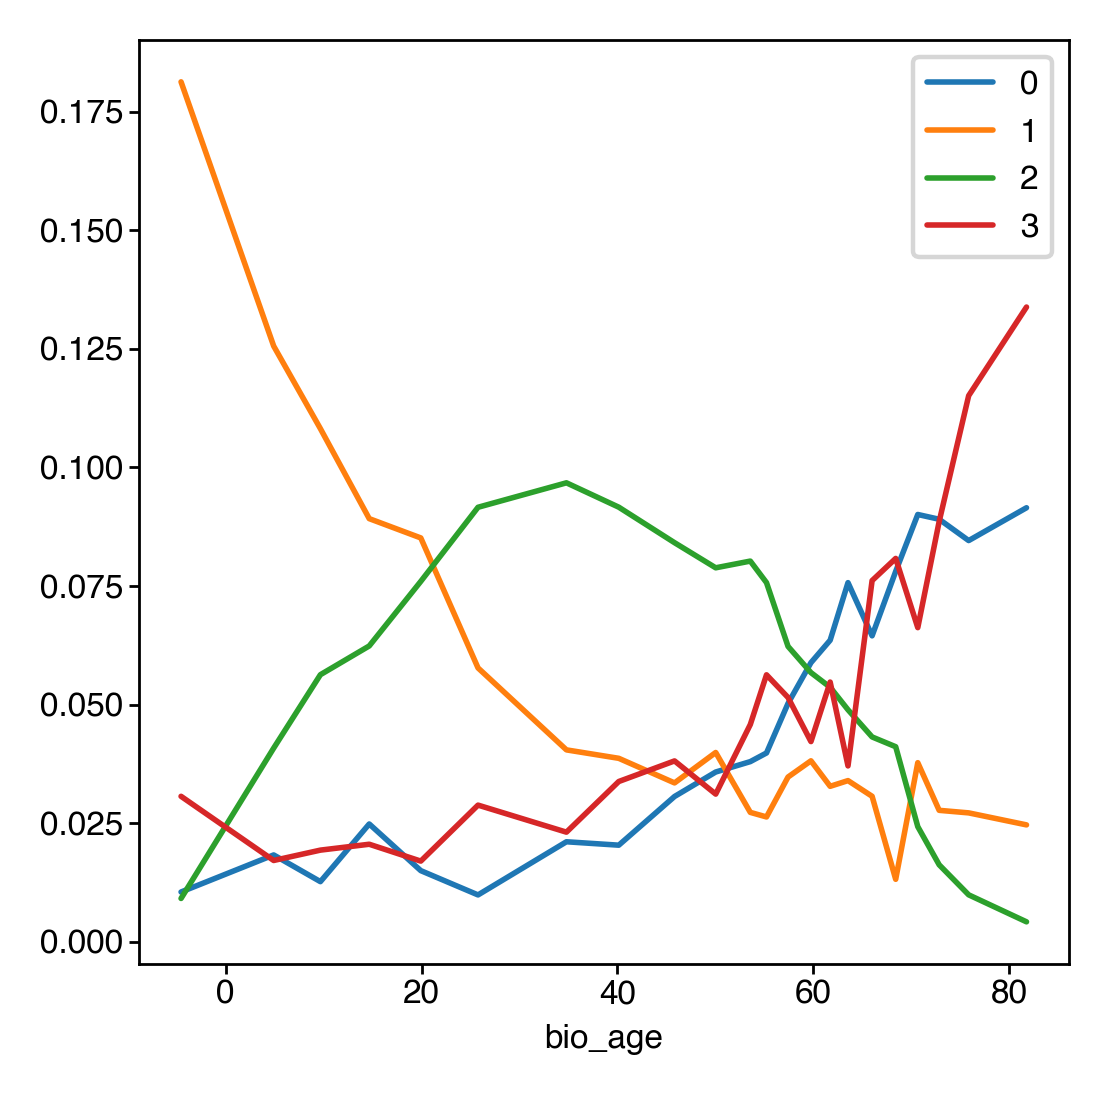

In [143]:
nmf_scores_df.groupby('bio_age').mean().plot()

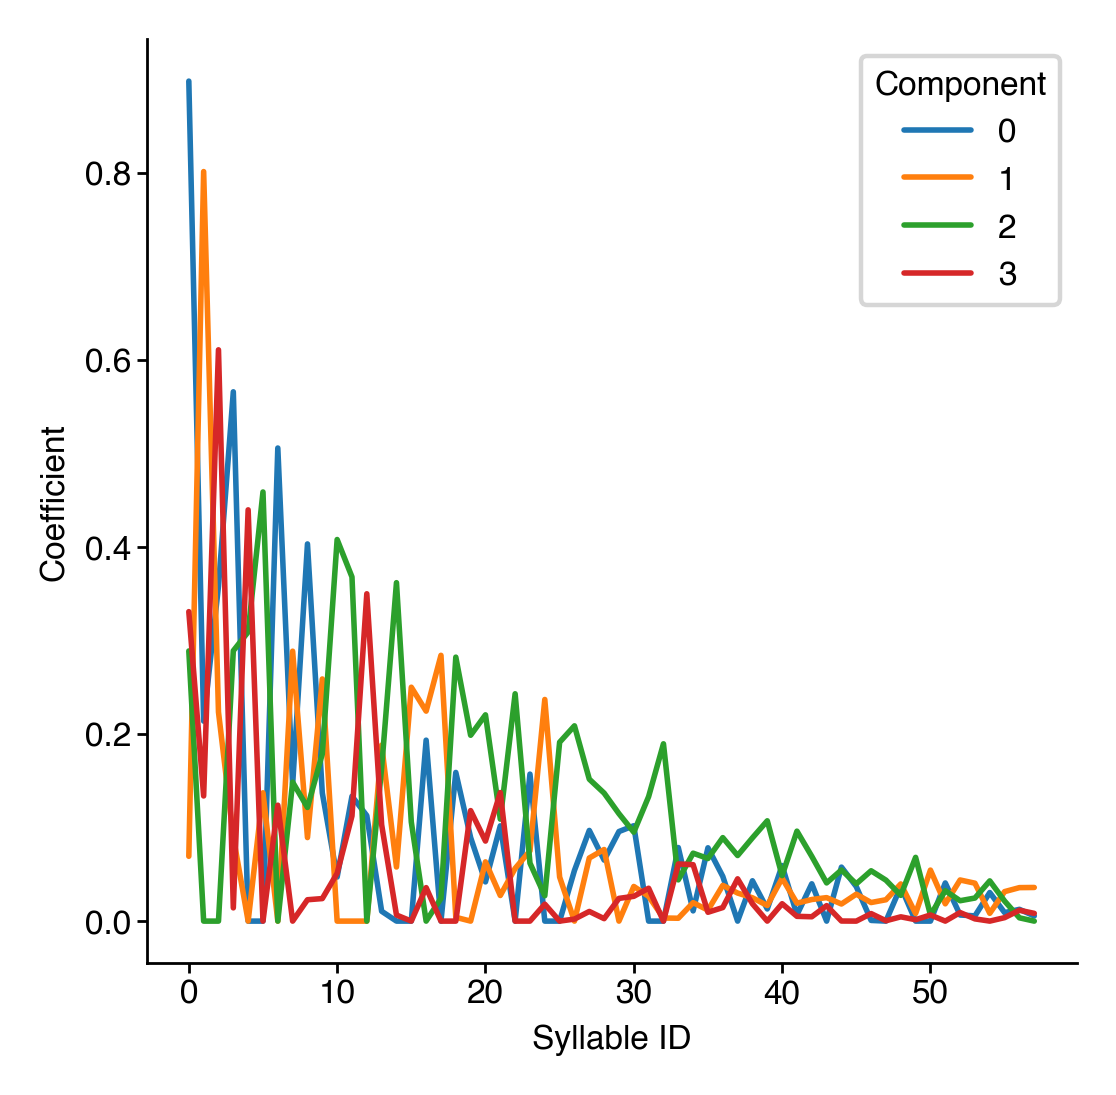

In [144]:
coefs = nmf.components_

srt_idx = np.argsort(df.quantile(0.9).to_numpy())[::-1]

plt.plot(coefs[:, srt_idx].T, label=range(4))
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")
plt.legend(title="Component")
sns.despine()

Text(0, 0.5, 'Coefficient')

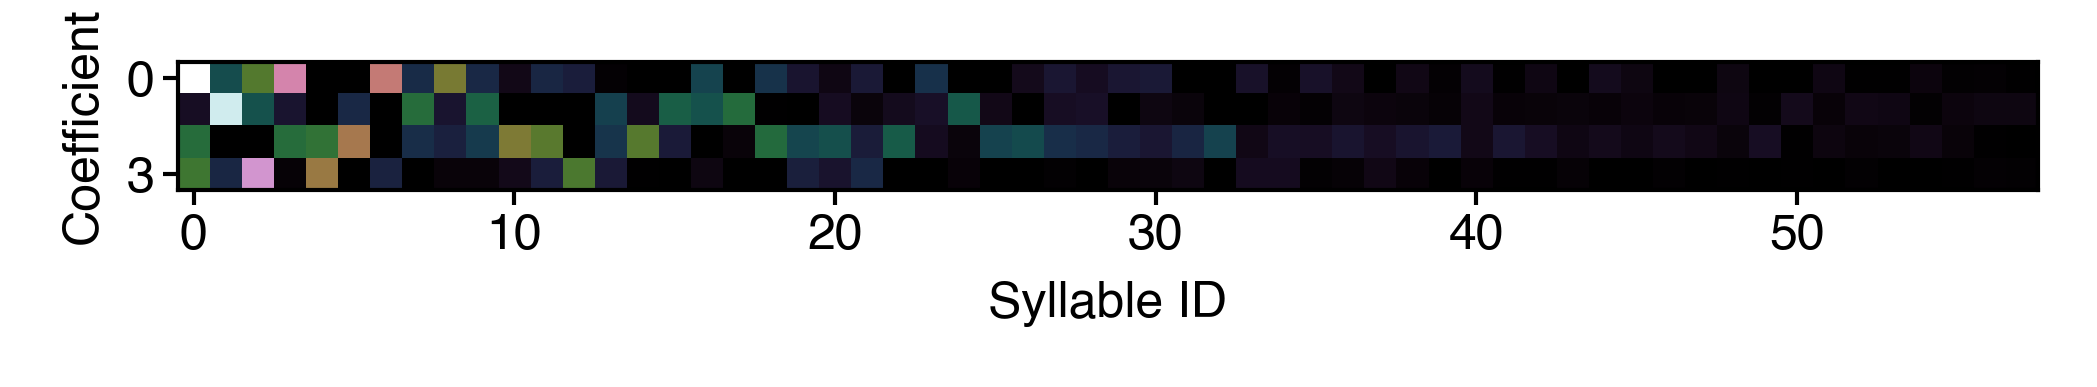

In [145]:
figure(4, 2)
plt.imshow(coefs[:, srt_idx], cmap='cubehelix')
plt.yticks([0, 3])
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")

In [146]:
syllable_coef_map = pd.DataFrame(dict(zip(df.columns, np.argmax(coefs, axis=0))), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()
syllable_coef_map['syll_class'] = syllable_coef_map['syllable'].map(id_map)
syllable_coef_map.groupby('component')['syll_class'].value_counts()

component  syll_class 
0          Walk            4
           Rear up         3
           Investigate     2
           Pause           1
           Run             1
1          Rear up         6
           Walk            3
           Pause           2
           Rear down       2
           Run             1
           Scrunch         1
2          Rear up        14
           Investigate     4
           Rear down       3
           Run             3
           Walk            3
           Groom           1
3          Groom           2
           Investigate     1
           Pause           1
Name: count, dtype: int64

### NMF - minmax norm

In [147]:
def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [148]:
nmf = NMF(n_components=4, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(df))

In [149]:
bam = pd.Series(mdl['bio_ages']).groupby(bio_age_map).mean()

In [150]:
nmf_scores_df = pd.DataFrame(scores, df.index)
nmf_scores_df['bio_age'] = pd.Series(bio_age_map).map(bam).to_numpy()
nmf_scores_df = nmf_scores_df.set_index('bio_age', append=True)

<Axes: xlabel='age'>

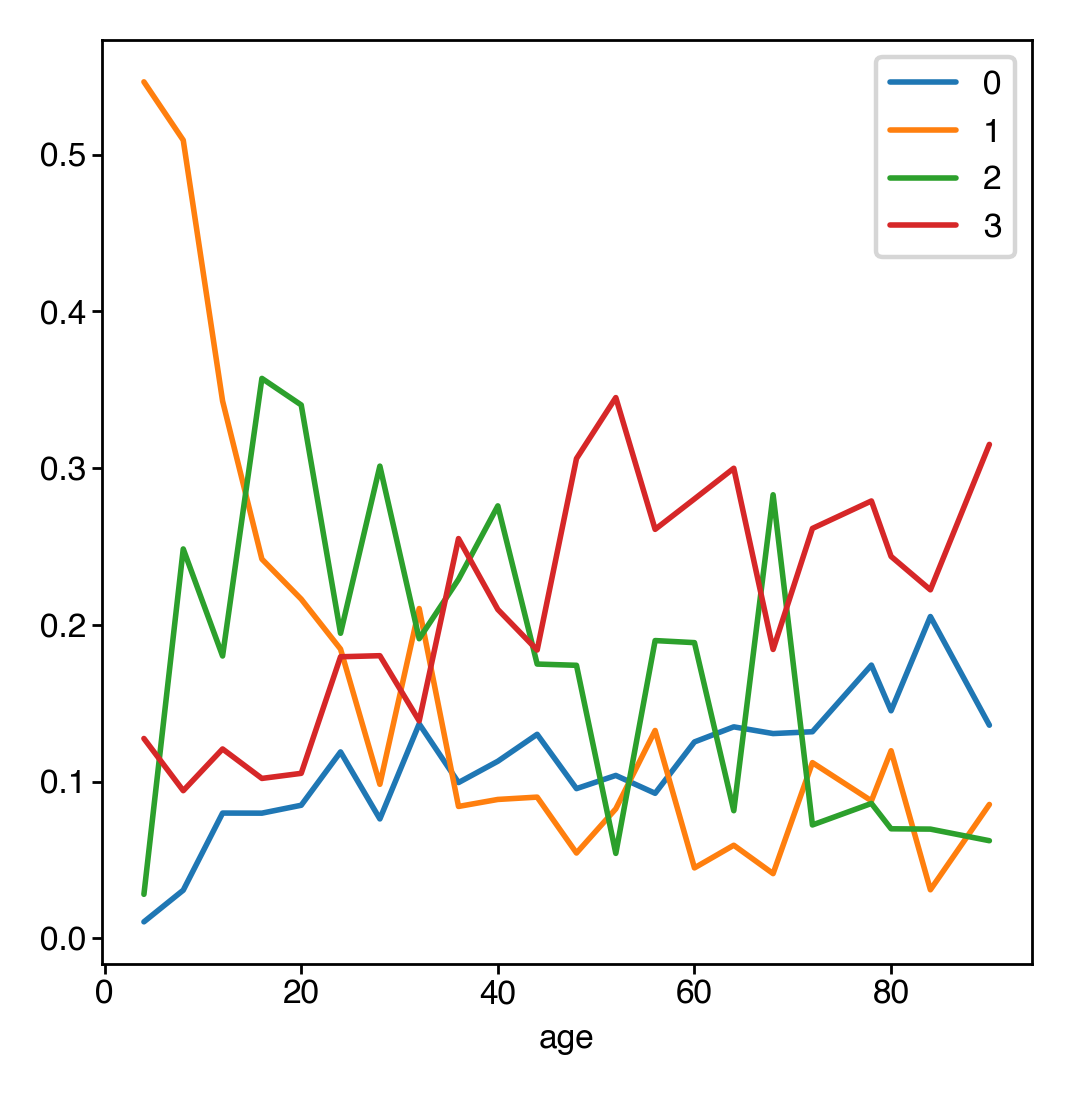

In [151]:
nmf_scores_df.groupby('age').mean().plot()

<Axes: xlabel='bio_age'>

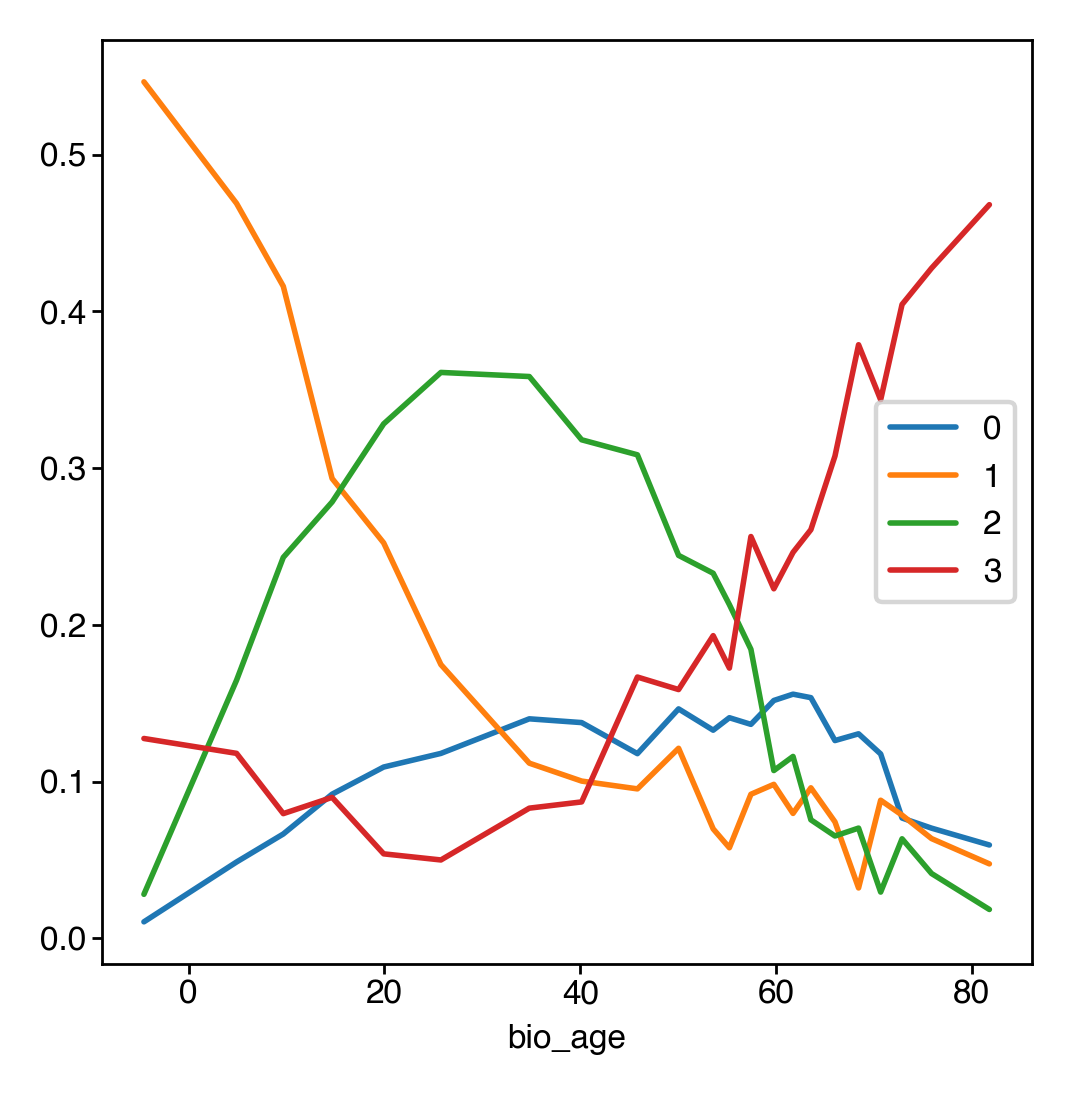

In [152]:
nmf_scores_df.groupby('bio_age').mean().plot()

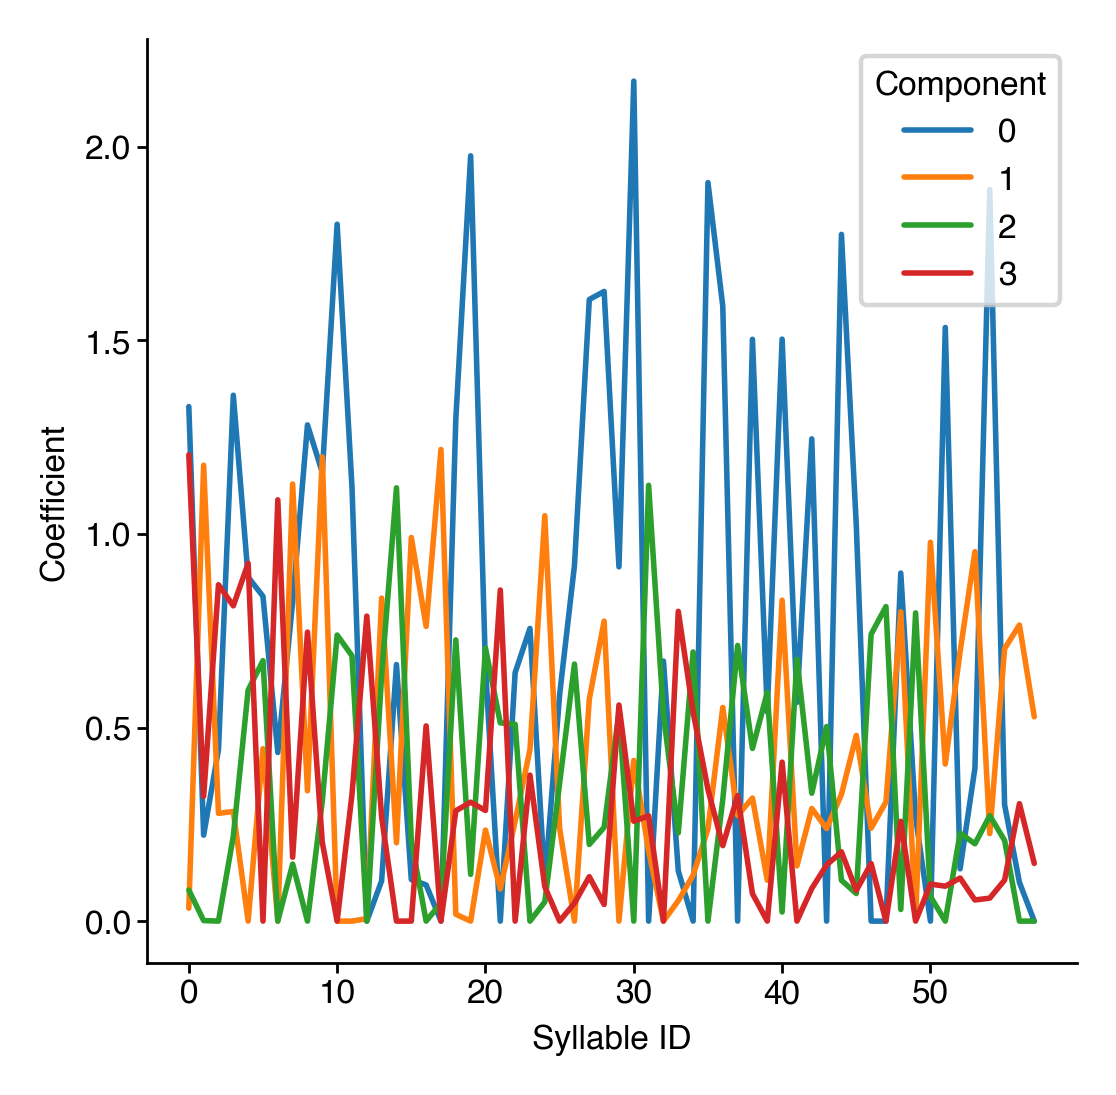

In [153]:
coefs = nmf.components_

srt_idx = np.argsort(df.quantile(0.9).to_numpy())[::-1]

plt.plot(coefs[:, srt_idx].T, label=range(4))
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")
plt.legend(title="Component")
sns.despine()

Text(0, 0.5, 'Coefficient')

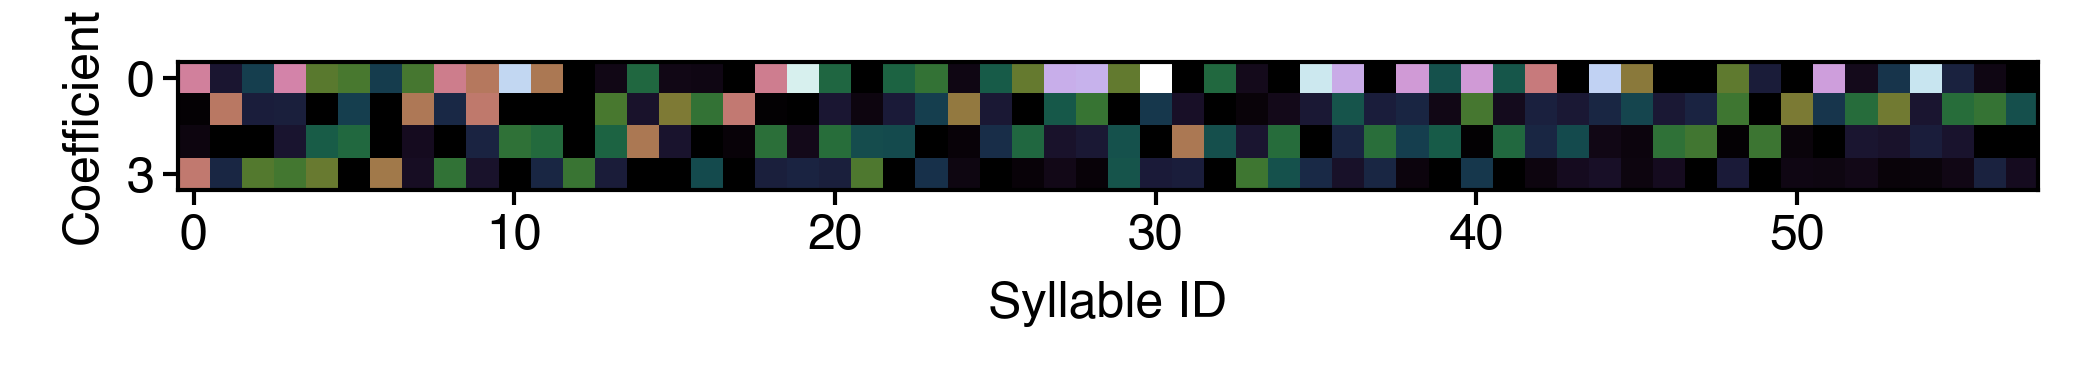

In [154]:
figure(4, 2)
plt.imshow(coefs[:, srt_idx], cmap='cubehelix')
plt.yticks([0, 3])
plt.xlabel("Syllable ID")
plt.ylabel("Coefficient")

In [155]:
syllable_coef_map = pd.DataFrame(dict(zip(df.columns, np.argmax(coefs, axis=0))), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()
syllable_coef_map['syll_class'] = syllable_coef_map['syllable'].map(id_map)
syllable_coef_map.groupby('component')['syll_class'].value_counts()

component  syll_class 
0          Rear up        11
           Walk            7
           Run             3
           Investigate     2
           Rear down       2
           Groom           1
           Pause           1
1          Rear up         5
           Walk            3
           Pause           2
           Rear down       2
           Run             1
           Scrunch         1
2          Rear up         7
           Investigate     2
           Rear down       1
           Run             1
3          Investigate     3
           Groom           2
           Pause           1
Name: count, dtype: int64

### K-Means minmax norm

In [156]:
from sklearn.cluster import k_means

In [190]:
n_clusters = 4
centroid, labels, inertia = k_means(minmax(df).T, n_clusters, random_state=4)

In [191]:
labels.shape

(58,)

In [192]:
syllable_coef_map = pd.DataFrame(dict(zip(df.columns, labels)), index=['component']).T
syllable_coef_map.index.name = "syllable"
syllable_coef_map = syllable_coef_map.reset_index()
syllable_coef_map['syll_class'] = syllable_coef_map['syllable'].map(id_map)
syllable_coef_map.groupby('component')['syll_class'].value_counts()

component  syll_class 
0          Rear up        8
           Investigate    2
           Rear down      2
           Run            2
           Walk           2
1          Rear up        9
           Walk           3
           Pause          2
           Rear down      1
           Run            1
2          Investigate    5
           Groom          3
           Walk           2
           Rear down      1
           Run            1
3          Rear up        6
           Walk           3
           Pause          2
           Rear down      1
           Run            1
           Scrunch        1
Name: count, dtype: int64

In [193]:
component_sylls = syllable_coef_map.groupby('component')['syllable'].unique()

In [194]:
mm_df = minmax(df)

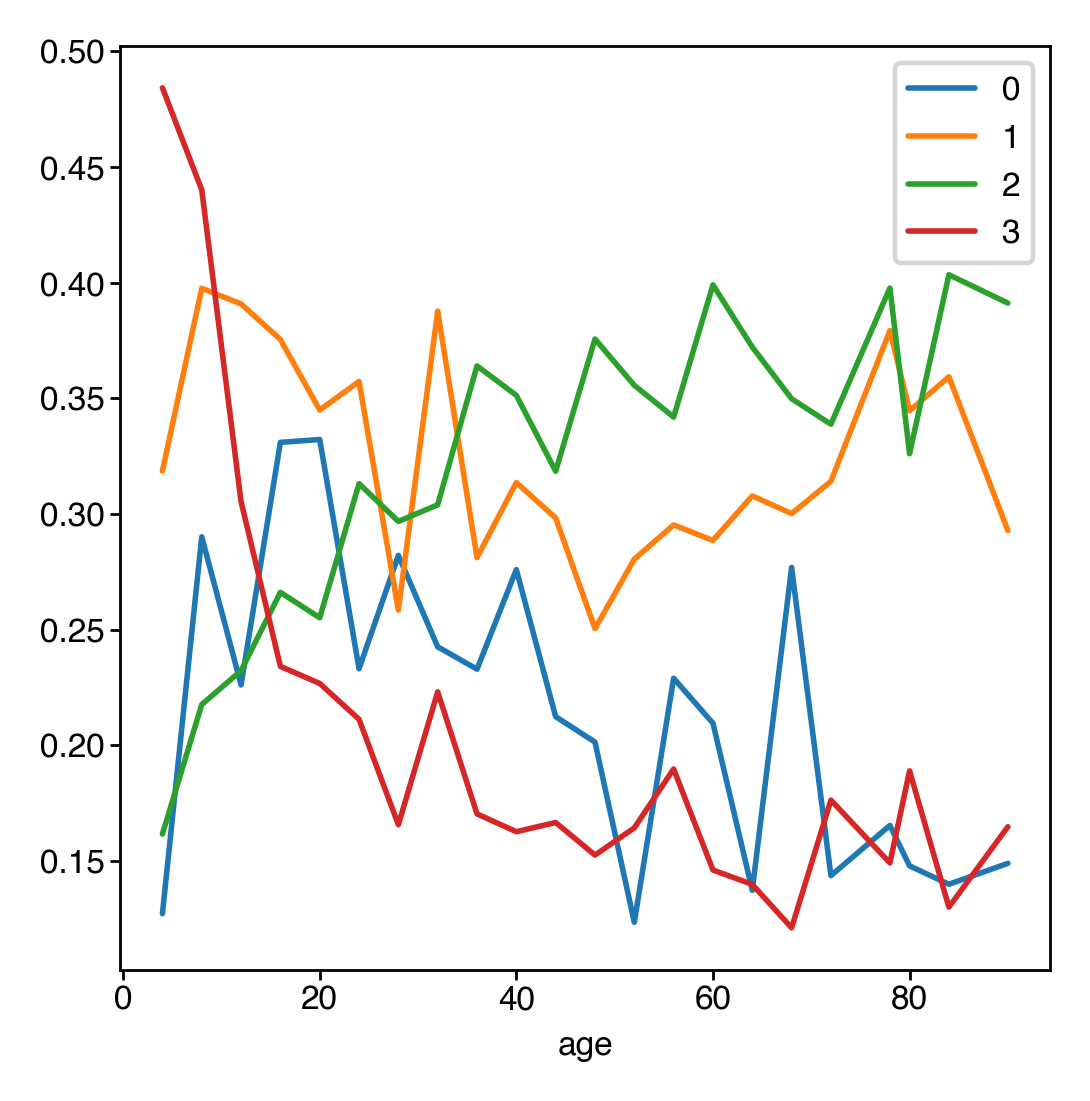

In [195]:
for i in range(n_clusters):
    mm_df[component_sylls.loc[i]].groupby('age').mean().mean(1).plot(label=i)
plt.legend()

###### 

In [174]:
filt_df = nmf_scores_df.query('age > 70').reset_index()

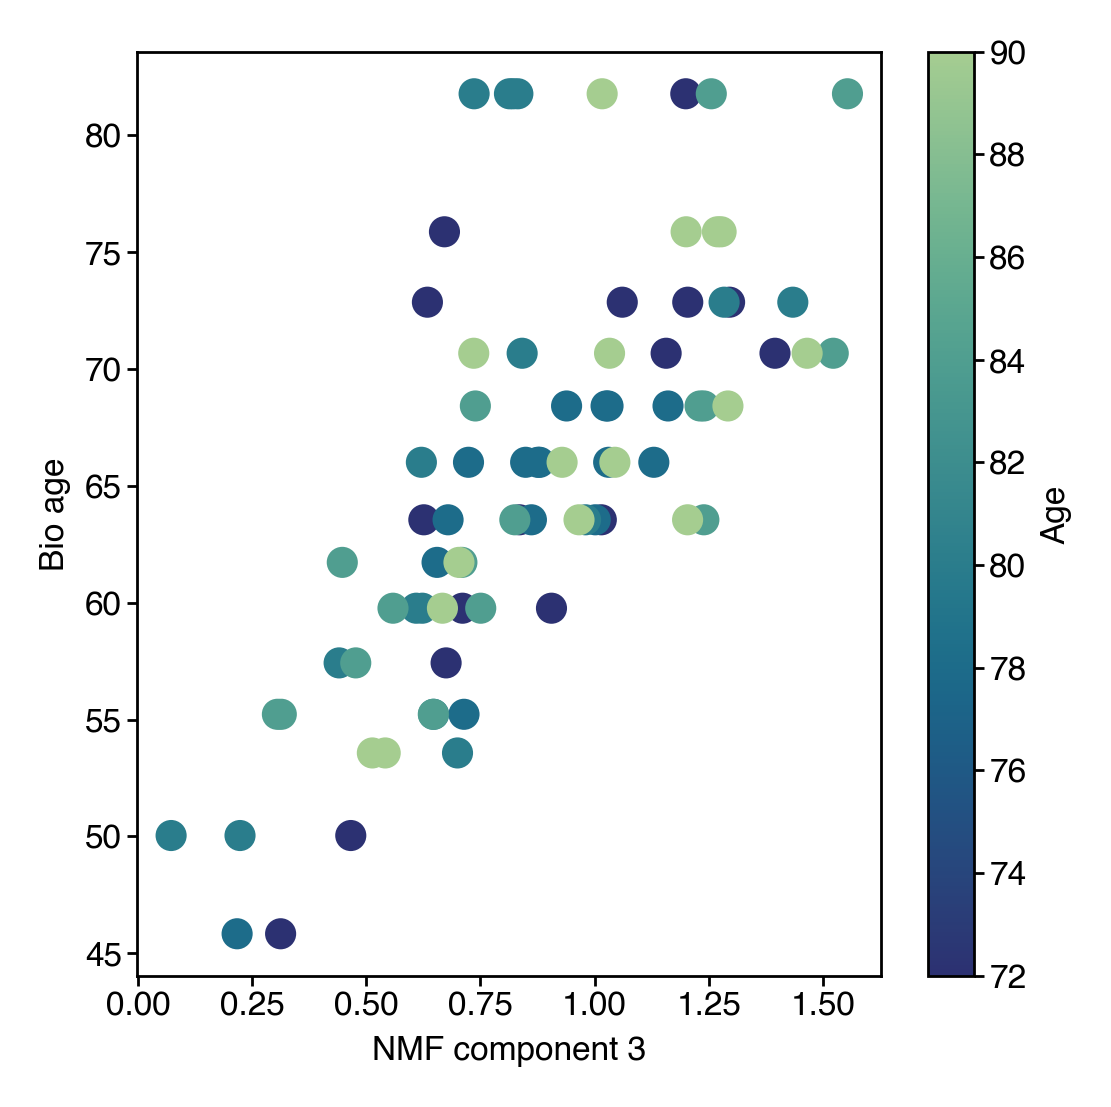

In [182]:
plt.scatter(filt_df[3], filt_df['bio_age'], c=filt_df['age'], cmap='crest_r')
plt.xlabel("NMF component 3")
plt.ylabel("Bio age")
plt.colorbar(label='Age')

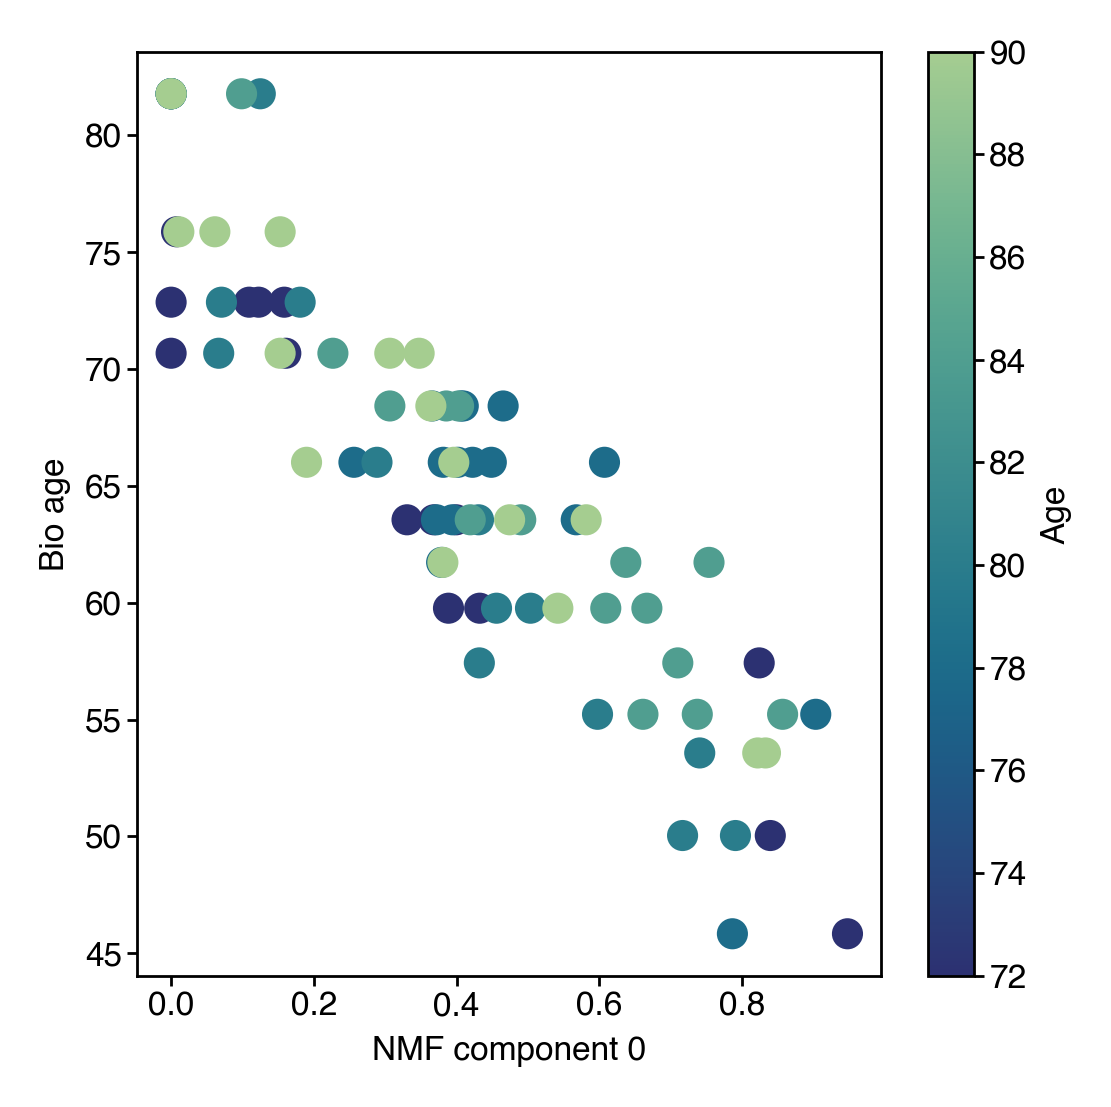

In [183]:
plt.scatter(filt_df[0], filt_df['bio_age'], c=filt_df['age'], cmap='crest_r')
plt.xlabel("NMF component 0")
plt.ylabel("Bio age")
plt.colorbar(label='Age')

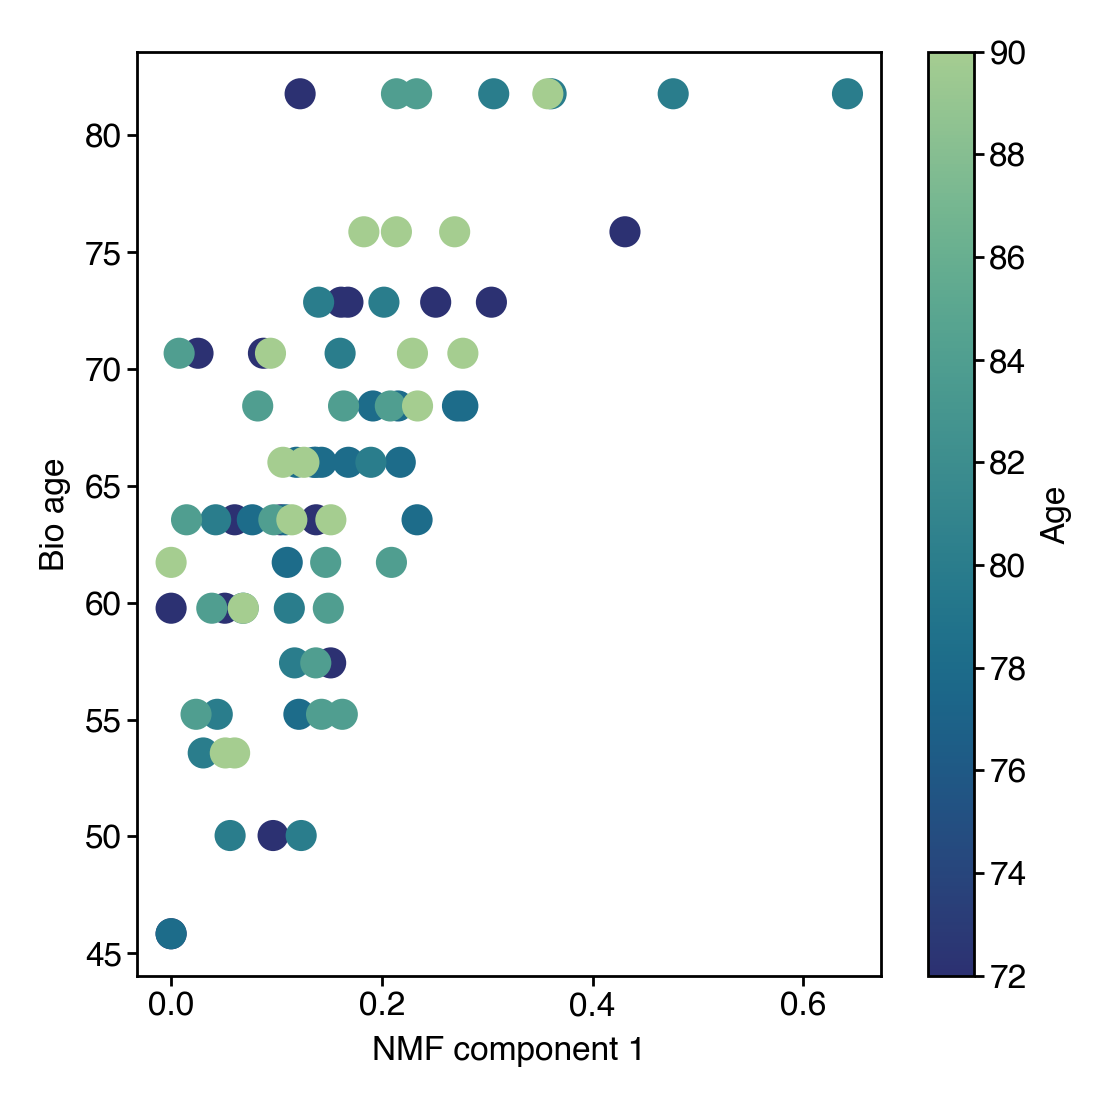

In [185]:
plt.scatter(filt_df[1], filt_df['bio_age'], c=filt_df['age'], cmap='crest_r')
plt.xlabel("NMF component 1")
plt.ylabel("Bio age")
plt.colorbar(label='Age')

## Females

In [100]:
df, sizes_col = read_female_ontogeny(keep_syllables)
# female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
# df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

# label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
# sex_id = label_encoder.fit_transform(
#     np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
# ).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [123]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    # "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    # "mice": sex_id,
}

hypparams = {
    # "min_age": 1,
    "min_age": -10,
    # "max_age": age.max() + 5,
    "max_age": 150,
    "age_sd": 10,  # weeks
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    # "n_animals": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 300,
}

In [124]:
mdl = fit_model(features, hypparams, 2)

In [125]:
pca = PCA(n_components=3)
scores = pca.fit_transform(df)
bio_pred_scores = pca.transform(mdl['predicted_counts'])
bio_pred_scores_df = pd.DataFrame(bio_pred_scores, index=df.index)

scores_df = pd.DataFrame(scores, index=df.index)

age_np = pd.Series(np.array(age))

bio_age_map = pd.qcut(mdl['bio_ages'], len(np.unique(age_np)), labels=False)
scores_df['bio_age'] = bio_age_map
scores_df = scores_df.set_index('bio_age', append=True)

bio_pred_scores_df['bio_age'] = bio_age_map
bio_pred_scores_df = bio_pred_scores_df.set_index('bio_age', append=True)

avgs = scores_df.groupby('age').mean()
bio_avgs = scores_df.groupby('bio_age').mean()
bio_pred_avgs = bio_pred_scores_df.groupby('age').mean()
bio_pred_avgs_bio = bio_pred_scores_df.groupby('bio_age').mean()

In [126]:
norm = plt.Normalize(vmin=avgs.index.min(), vmax=avgs.index.max())
cmap = plt.colormaps['viridis']
norm2 = plt.Normalize(vmin=bio_avgs.index.min(), vmax=bio_avgs.index.max())
cmap2 = plt.colormaps['inferno']
cmap3 = plt.colormaps['turbo']
cmap4 = plt.colormaps['twilight_r']

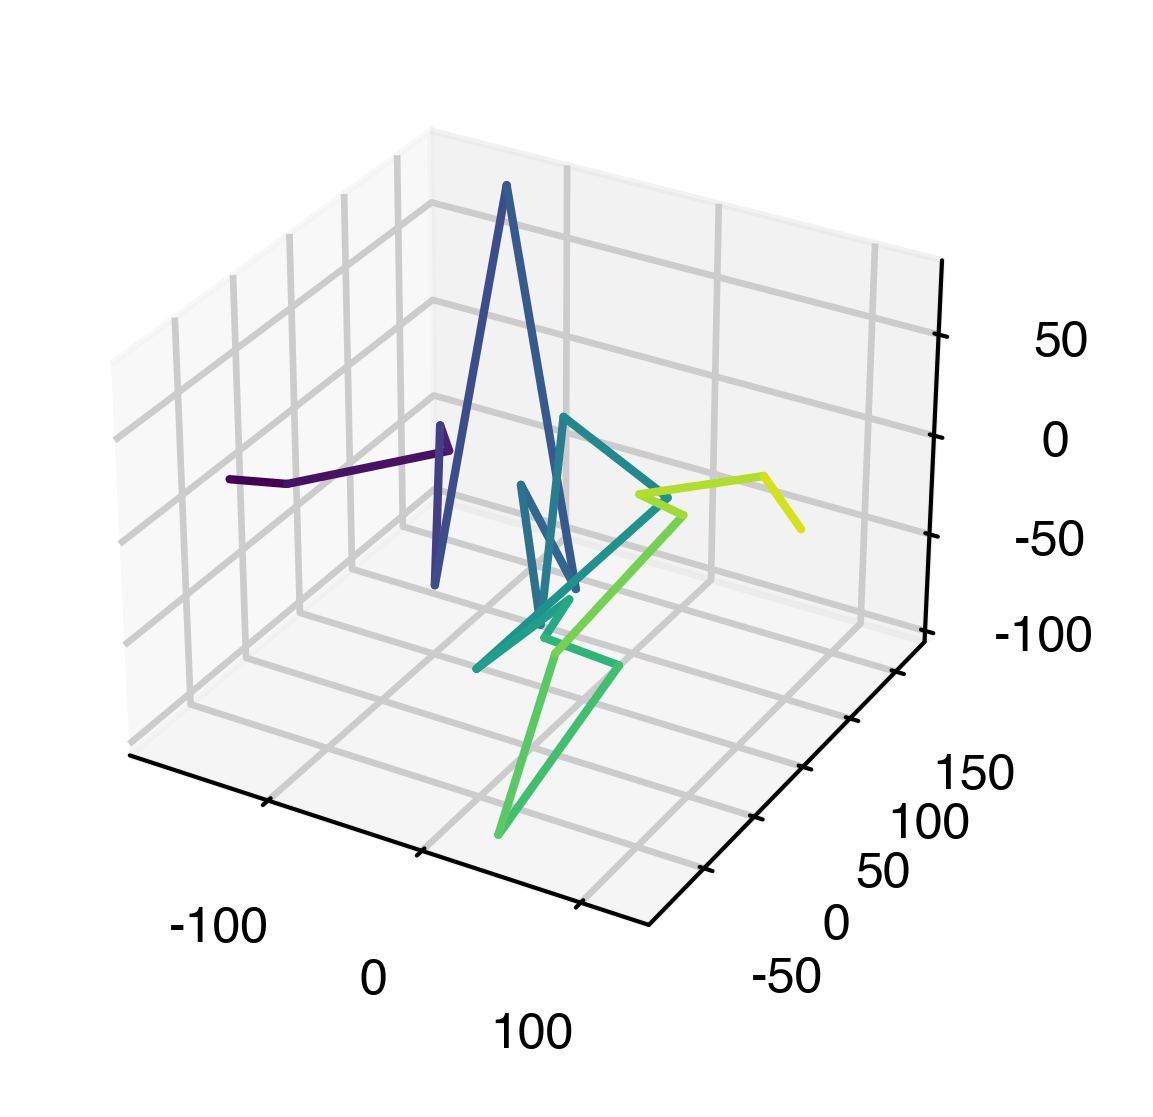

In [127]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap3(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs_bio.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))

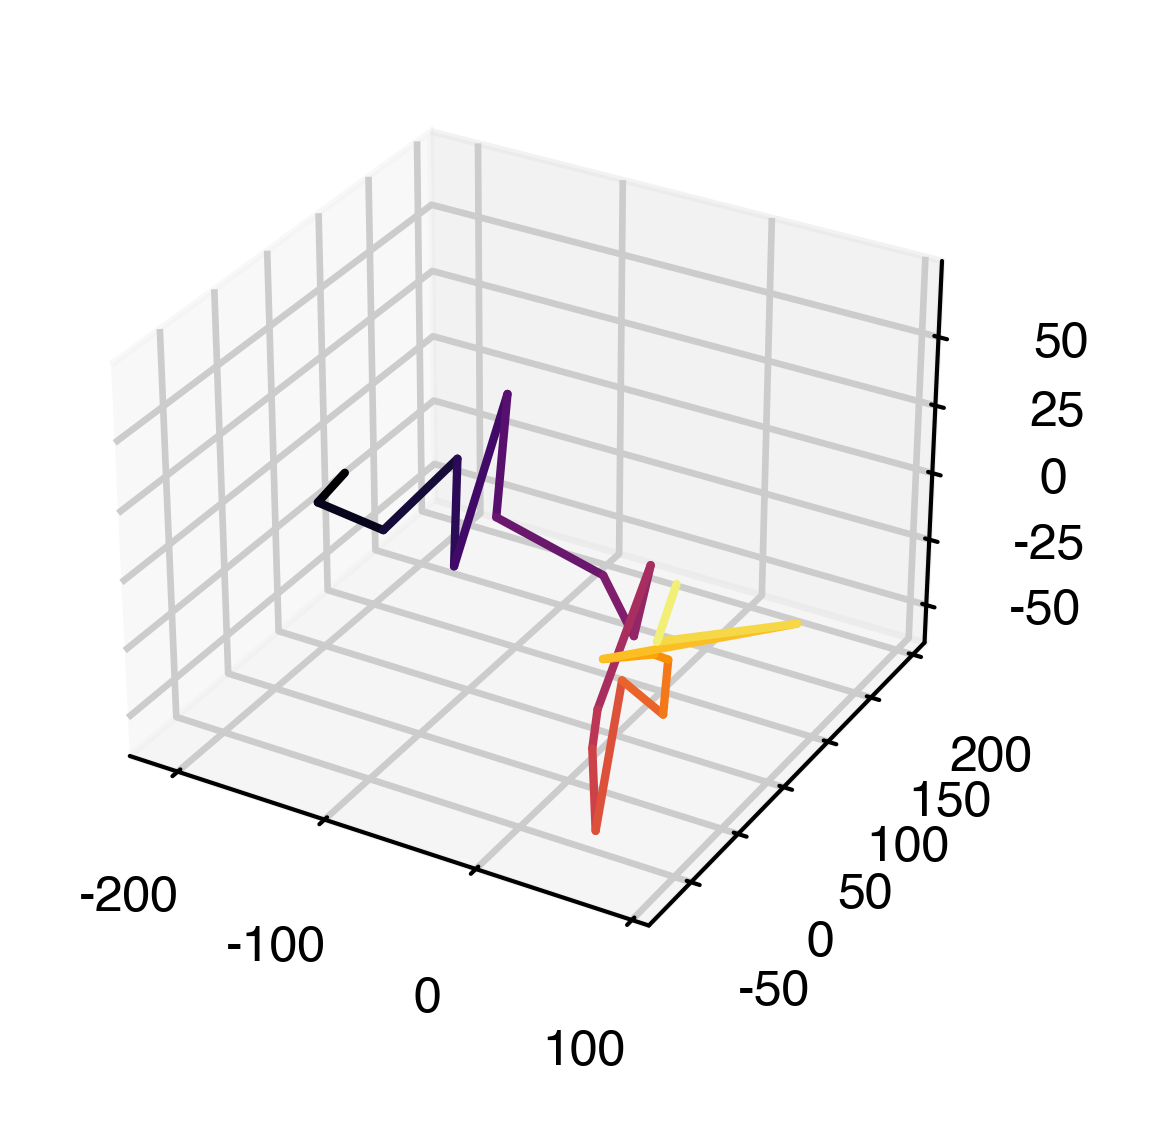

In [128]:
fig = figure(2, 2)
ax = fig.add_subplot(111, projection='3d')
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
#     ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], [_df1[2], _df2[2]], color=cmap2(norm2(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap3(norm(_age1)))
# for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_pred_avgs_bio.iterrows()):
#     plt.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))

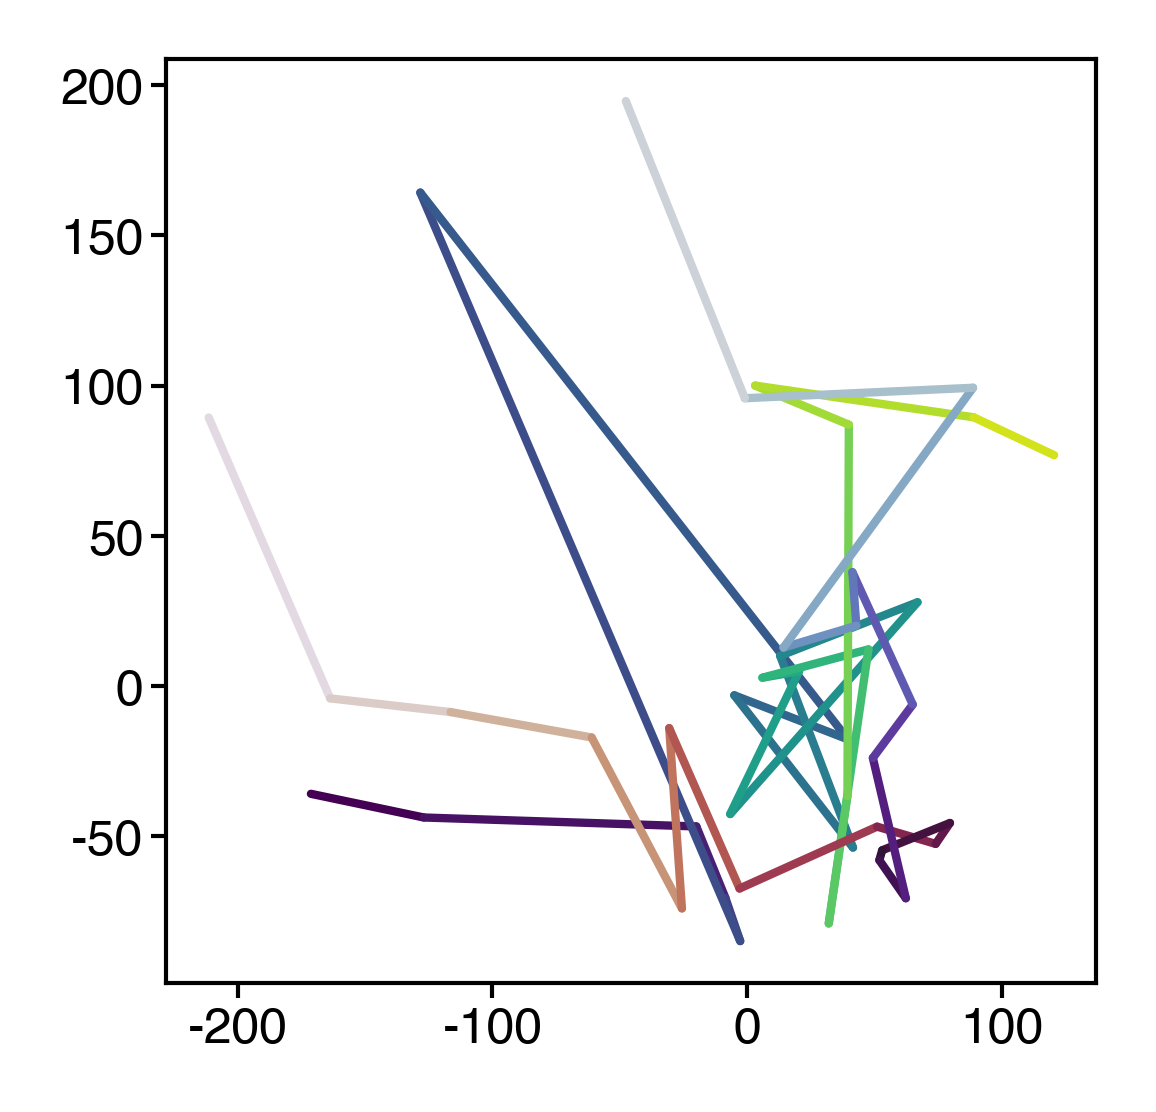

In [129]:
fig = figure(2, 2)
ax = fig.gca()
for (_age1, _df1), (_age2, _df2) in sliding_window(2, avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap(norm(_age1)))
for (_age1, _df1), (_age2, _df2) in sliding_window(2, bio_avgs.iterrows()):
    ax.plot([_df1[0], _df2[0]], [_df1[1], _df2[1]], color=cmap4(norm2(_age1)))